## Happiness Metrics for Global Life Expectancy Predictive Analysis
Nicole Chang, Sourish Guntipally, Aaron Park, Brandon To

Data used for this project is from Kaggle datasets of the [World Happiness Report](https://www.kaggle.com/unsdsn/world-happiness?select=2019.csv) and [Human Life Expectancy Around the World](https://www.kaggle.com/deepcontractor/human-life-expectancy-around-the-world).

The years we are analyzing are from 2015 - 2019.

In [843]:
import scipy as sp, numpy as np, pandas as pd
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import LeaveOneGroupOut, LeaveOneOut
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score, cross_val_predict
import warnings
warnings.simplefilter('ignore')

____

## Data Importation and Data Processing

In [844]:
#World Happiness Report (WHR)
#Human Life Expectancy Around the World (HLE)
#Use command below to show all elements in a dataframe
#pd.set_option("display.max_rows", None, "display.max_columns", None)

#HLE
dataHLE = pd.read_csv('Human_life_Expectancy.csv')

#2015 data
dataWHR2015 = pd.read_csv('2015.csv') #WHR

#2016 data
dataWHR2016 = pd.read_csv('2016.csv') #WHR

#2017 data
dataWHR2017 = pd.read_csv('2017.csv') #WHR

#2018 data
dataWHR2018 = pd.read_csv('2018.csv') #WHR

#2019 data
dataWHR2019 = pd.read_csv('2019.csv') #WHR

In [845]:
#Configuring HLE dataframe
dataHLE_NSN = dataHLE.set_index('Level')
dataHLE_NSN = dataHLE_NSN.drop('subnational')

In [846]:
#Configuring data into dataframes that are easier to use 

#Labels are the names of the measurements (countries) for all 5 years
labels = [dataWHR2015['Country'].astype(str), dataWHR2016['Country'].astype(str), dataWHR2017['Country'].astype(str),dataWHR2018['Country'].astype(str), dataWHR2019['Country'].astype(str), dataHLE_NSN['Country'].astype(str)] 
#dictionary to track countries participation in all 5 years
recurringCountries = {}

for i in range(len(dataWHR2015['Country'])):
    recurringCountries[labels[0][i]] = 1

for year in range(5):                                                      #Iterates for each year after 2015
    for countryind in range(len(dataWHR2015['Country'])):                  #Iterates through country labels for 2015
        for matchind in range(len(labels[year+1][:])):                     #Finds matches between 2015 label and other years
            if labels[0][countryind] == labels[year+1][matchind]:
                recurringCountries[labels[0][countryind]] += 1

#delete all the countries that don't appear in every year out of the dictionary
for i in range(len(recurringCountries)):
    if recurringCountries[labels[0][i]] < 6:
        recurringCountries.pop(labels[0][i])


In [847]:
#creating lists of the countries to delete using the WHR dictionary 
del_countries2015 = []

for i in range(len(dataWHR2015['Country'])):
    if labels[0][i] not in recurringCountries:
        del_countries2015.append(labels[0][i])

del_countries2016 = []

for i in range(len(dataWHR2016['Country'])):
    if labels[1][i] not in recurringCountries:
        del_countries2016.append(labels[1][i])

del_countries2017 = []

for i in range(len(dataWHR2017['Country'])):
    if labels[2][i] not in recurringCountries:
        del_countries2017.append(labels[2][i])
        
del_countries2018 = []

for i in range(len(dataWHR2018['Country'])):
    if labels[3][i] not in recurringCountries:
        del_countries2018.append(labels[3][i])
        
del_countries2019 = []

for i in range(len(dataWHR2019['Country'])):
    if labels[4][i] not in recurringCountries:
        del_countries2019.append(labels[4][i])

del_countriesHLE = []

for i in range(len(dataHLE_NSN['Country'])):
    if labels[5][i] not in recurringCountries:
        del_countriesHLE.append(labels[5][i])

In [848]:
#feel free to rename these dataframes
#new dataframes with dropped countries
#Syria does not appear in HLE which is why it is dropped in all other dataframes

dfWHR2015 = dataWHR2015.set_index('Country')
dfWHR2015 = dfWHR2015.drop(del_countries2015)
dfWHR2015 = dfWHR2015.drop('Syria')
dfWHR2015 = dfWHR2015.reset_index()

dfWHR2016 = dataWHR2016.set_index('Country')
dfWHR2016 = dfWHR2016.drop(del_countries2016)
dfWHR2016 = dfWHR2016.drop('Syria')
dfWHR2016 = dfWHR2016.reset_index()

dfWHR2017 = dataWHR2017.set_index('Country')
dfWHR2017 = dfWHR2017.drop(del_countries2017)
dfWHR2017 = dfWHR2017.drop('Syria')
dfWHR2017 = dfWHR2017.reset_index()

dfWHR2018 = dataWHR2018.set_index('Country')
dfWHR2018 = dfWHR2018.drop(del_countries2018)
dfWHR2018 = dfWHR2018.drop('Syria')
dfWHR2018 = dfWHR2018.reset_index()

dfWHR2019 = dataWHR2019.set_index('Country')
dfWHR2019 = dfWHR2019.drop(del_countries2019)
dfWHR2019 = dfWHR2019.drop('Syria')
dfWHR2019 = dfWHR2019.reset_index()


dfHLE = dataHLE_NSN.set_index('Country')
dfHLE = dfHLE.drop(del_countriesHLE)
dfHLE = dfHLE.drop('Syria')
dfHLE = dfHLE.reset_index()

dfHLE2015 = dfHLE['2015'] #data frame HLE 2015
dfHLE2016 = dfHLE['2016'] #data frame HLE 2016
dfHLE2017 = dfHLE['2017'] #data frame HLE 2017
dfHLE2018 = dfHLE['2018'] #data frame HLE 2018
dfHLE2019 = dfHLE['2019'] #data frame HLE 2019


In [849]:
# if you want to drop columns, here's an example below
#data_with_index1 = data_with_index1.drop(['Region', 'Standard Error'], axis=1)

In [850]:
# To alphabetize, follow below example.
# I left it like this so that we can call sort_values when needed. 
# Should just keep the main data frame sorted by overall rank by default
#data_with_index1.sort_values('Country') #sorting A-Z
#data_with_index1.sort_values('Country', ascending=False) #sorting Z-A

In [851]:
#To exclude certain columns
#dfWHR2015.loc[:, ~dfWHR2015.columns.isin(['Country', 'Region', 'Overall Rank'])]

#To exclude one column
#dfWHR2015.loc[:, dfWHR2015.columns != 'Country']

In [852]:
#Removing columns

dfWHR2015 = dfWHR2015.drop(['Overall Rank', 'Region', 'Standard Error', 'Healthy life expectancy', 'Dystopia Residual'], axis=1)
dfWHR2016 = dfWHR2016.drop(['Overall Rank', 'Region', 'Lower Confidence Interval', 'Upper Confidence Interval', 'Healthy life expectancy', 'Dystopia Residual'], axis=1)
dfWHR2017 = dfWHR2017.drop(['Overall Rank', 'Whisker.high', 'Whisker.low', 'Healthy life expectancy', 'Dystopia Residual'], axis=1)
dfWHR2018 = dfWHR2018.drop(['Overall rank', 'Healthy life expectancy'], axis=1)
dfWHR2019 = dfWHR2019.drop(['Overall rank', 'Healthy life expectancy'], axis=1)

## PLSR 2015

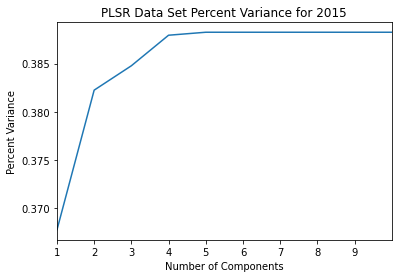

In [853]:
#PLSR 2015
#133 total countries in each dataframe
Y_WHRHLE2015 = pd.concat([dfWHR2015, dfHLE2015], axis=1)
tempdfWHR2015 = dfWHR2015.drop('Happiness Score', axis=1)
X2015 = tempdfWHR2015.values[:, 1:]
Y2015 = Y_WHRHLE2015[['Happiness Score', '2015']]
r2y2015 = np.zeros(133)

for i in range(0,133):
    plsrModel2015 = PLSRegression(n_components=i)
    plsrModel2015.fit(X2015, Y2015)
    r2y2015[i] = plsrModel2015.score(X2015,Y2015)

plt.plot(range(0,133), r2y2015)
plt.xlim(1,10)
plt.xticks(np.arange(1,10,1))
plt.xlabel('Number of Components')
plt.ylabel('Percent Variance')
plt.title('PLSR Data Set Percent Variance for 2015')
plt.show()

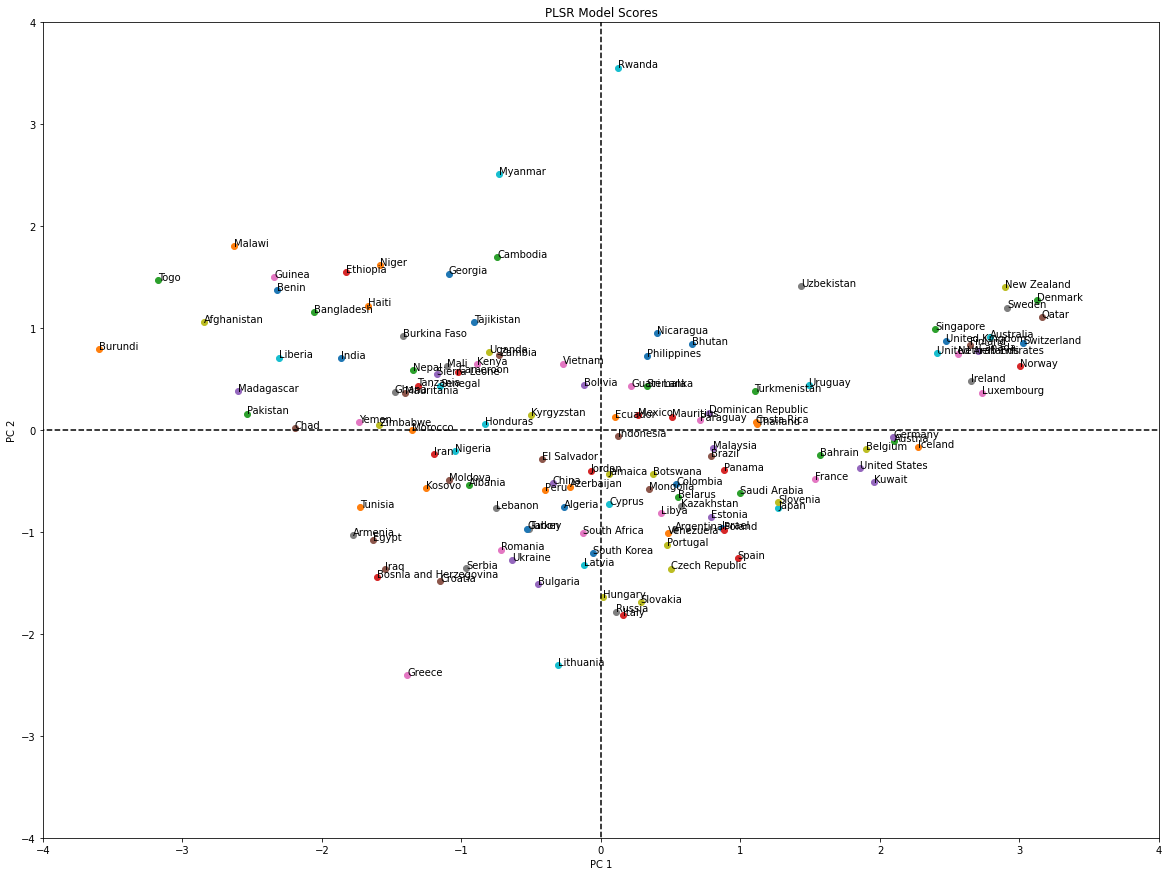

In [854]:
xScores2015 = plsrModel2015.x_scores_
yScores2015 = plsrModel2015.y_scores_
plt.figure(figsize=(20,15))

for i in range(0, 133):
    plt.scatter(xScores2015[i, 0], xScores2015[i, 1], label=dfWHR2015['Country'][i])
    plt.annotate(dfWHR2015['Country'][i], (xScores2015[i,0], xScores2015[i,1]))

plt.plot([0,0], [-10, 10], linestyle='--', color='k')
plt.plot([-10,10], [0,0], linestyle='--', color='k')
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PLSR Model Scores')
#plt.legend(bbox_to_anchor=(1.05,1.0), loc=2, prop={'size': 7}, ncol=4)
plt.show()


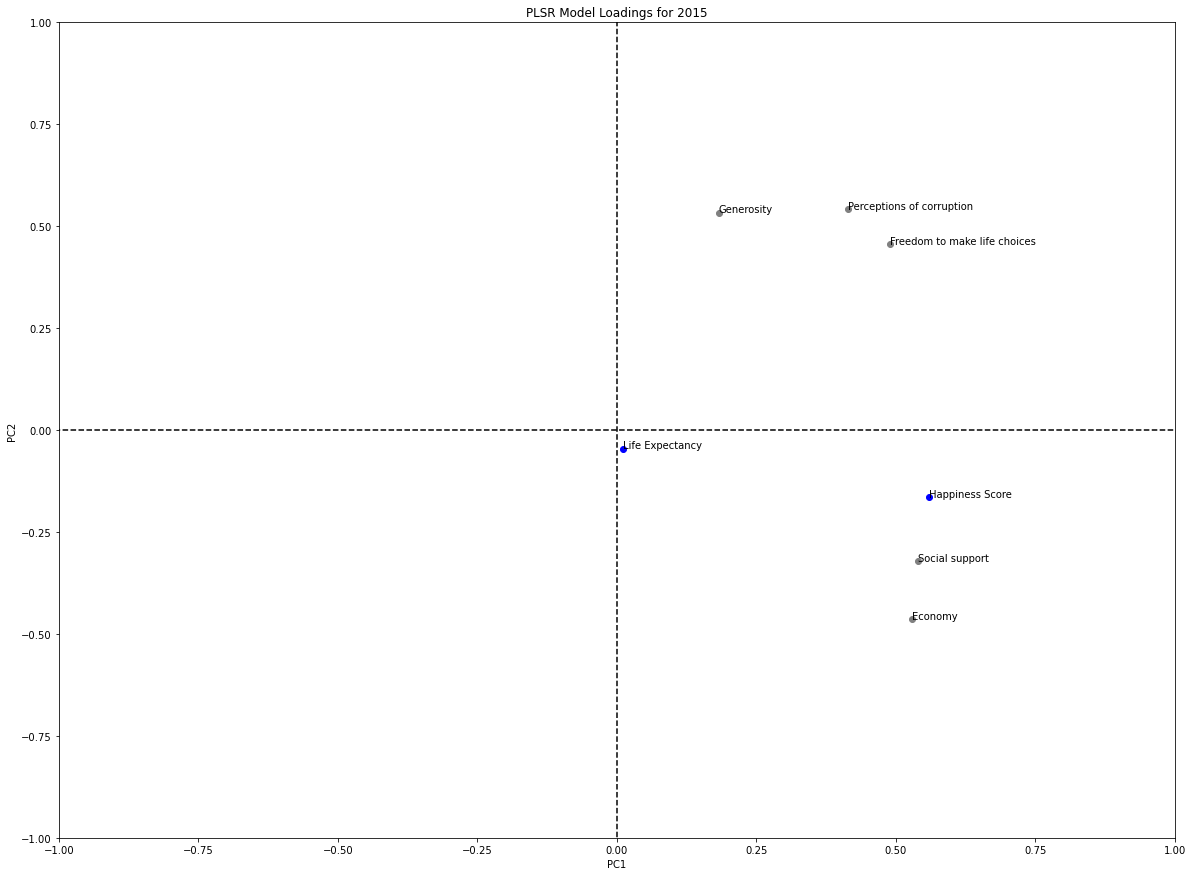

In [855]:
xLoad2015 = plsrModel2015.x_loadings_
yLoad2015 = plsrModel2015.y_loadings_

plt.figure(figsize=(20,15))
plt.scatter(xLoad2015[:,0], xLoad2015[:,1], c='gray')
plt.scatter(yLoad2015[:,0], yLoad2015[:,1], c='blue')
plt.annotate('Happiness Score', (yLoad2015[0,0], yLoad2015[0,1]))
plt.annotate('Life Expectancy', (yLoad2015[1,0], yLoad2015[1,1]))


labelArr = ['Economy', 'Social support', 'Freedom to make life choices', 'Perceptions of corruption', 'Generosity']

for i in range(xLoad2015.shape[0]):
        plt.text(xLoad2015[i,0], xLoad2015[i,1], labelArr[i])
        
plt.plot([0,0], [-5, 5], linestyle='--', color='k')
plt.plot([-5,5], [0,0], linestyle='--', color='k')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PLSR Model Loadings for 2015')
plt.show()

------------

## PLSR 2016

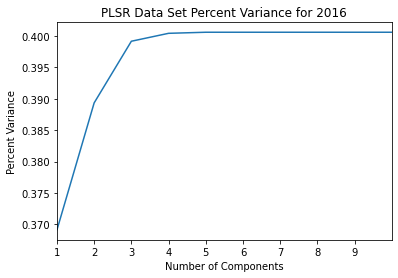

In [856]:
#PLSR 2016
#133 total countries in each dataframe
Y_WHRHLE2016 = pd.concat([dfWHR2016, dfHLE2016], axis=1)
tempdfWHR2016 = dfWHR2016.drop('Happiness Score', axis=1)
X2016 = tempdfWHR2016.values[:, 1:]
Y2016 = Y_WHRHLE2016[['Happiness Score', '2016']]
r2y2016 = np.zeros(133)

for i in range(0,133):
    plsrModel2016 = PLSRegression(n_components=i)
    plsrModel2016.fit(X2016, Y2016)
    r2y2016[i] = plsrModel2016.score(X2016,Y2016)

plt.plot(range(0,133), r2y2016)
plt.xlim(1,10)
plt.xticks(np.arange(1,10,1))
plt.xlabel('Number of Components')
plt.ylabel('Percent Variance')
plt.title('PLSR Data Set Percent Variance for 2016')
plt.show()

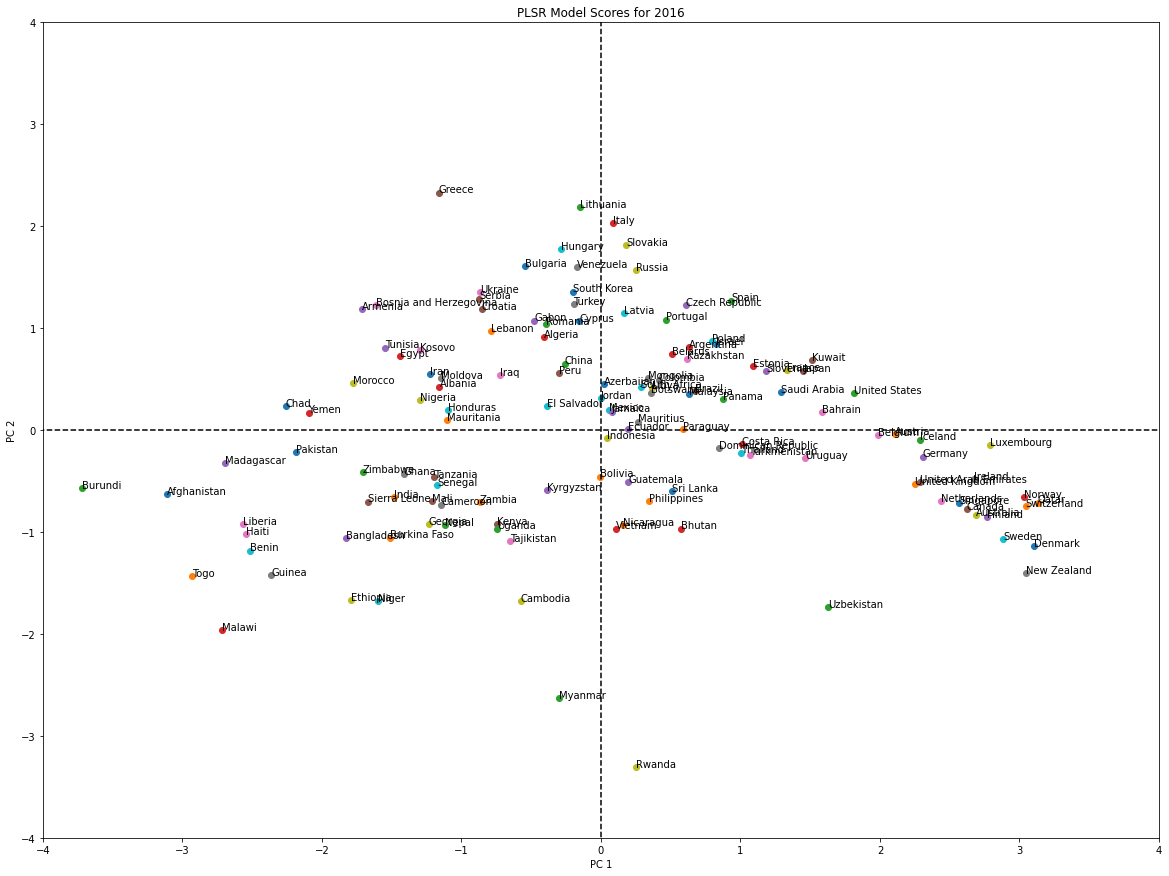

In [857]:
xScores2016 = plsrModel2016.x_scores_
yScores2016 = plsrModel2016.y_scores_
plt.figure(figsize=(20,15))

for i in range(0, 133):
    plt.scatter(xScores2016[i, 0], xScores2016[i, 1], label=dfWHR2016['Country'][i])
    plt.annotate(dfWHR2016['Country'][i], (xScores2016[i,0], xScores2016[i,1]))

plt.plot([0,0], [-10, 10], linestyle='--', color='k')
plt.plot([-10,10], [0,0], linestyle='--', color='k')
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PLSR Model Scores for 2016')
#plt.legend(bbox_to_anchor=(1.05,1.0), loc=2, prop={'size': 7}, ncol=4)
plt.show()

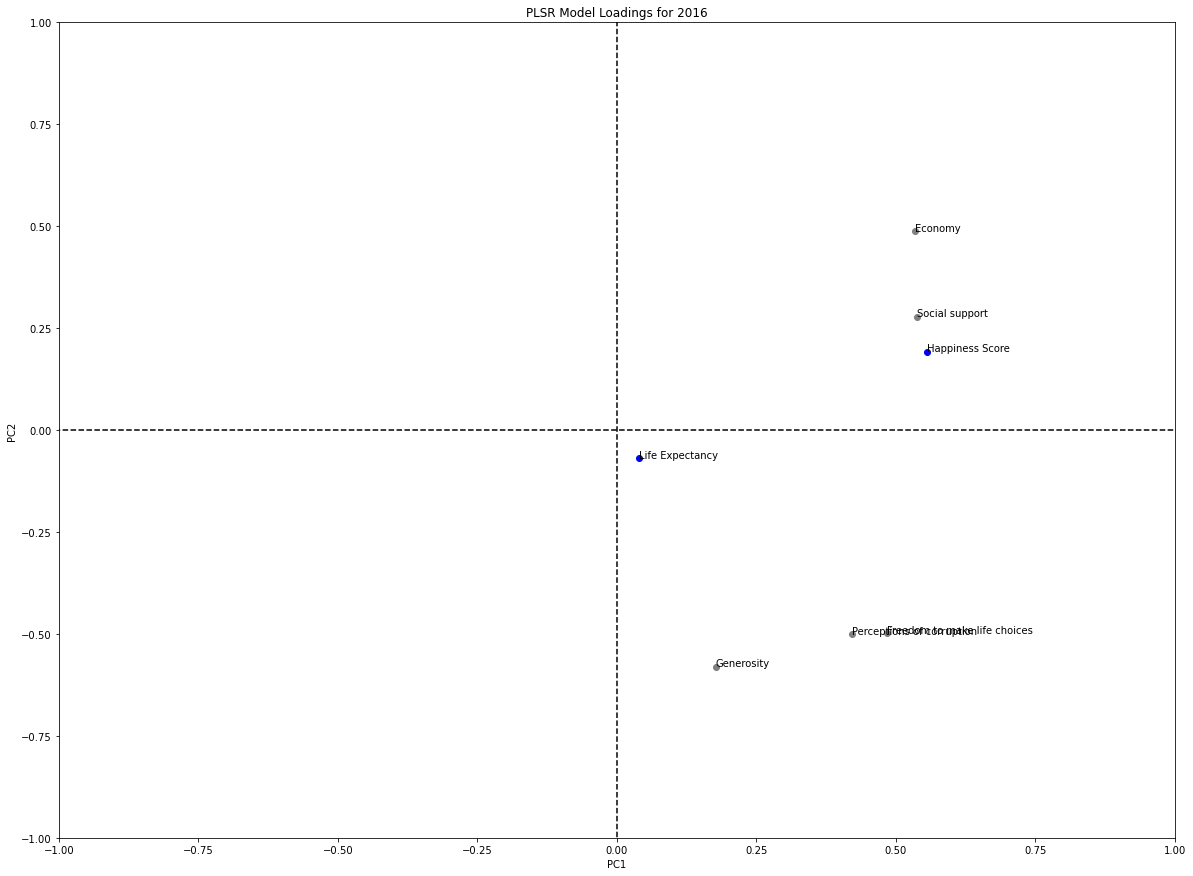

In [858]:
xLoad2016 = plsrModel2016.x_loadings_
yLoad2016 = plsrModel2016.y_loadings_

plt.figure(figsize=(20,15))
plt.scatter(xLoad2016[:,0], xLoad2016[:,1], c='gray')
plt.scatter(yLoad2016[:,0], yLoad2016[:,1], c='blue')
plt.annotate('Happiness Score', (yLoad2016[0,0], yLoad2016[0,1]))
plt.annotate('Life Expectancy', (yLoad2016[1,0], yLoad2016[1,1]))


labelArr = ['Economy', 'Social support', 'Freedom to make life choices', 'Perceptions of corruption', 'Generosity']

for i in range(xLoad2016.shape[0]):
        plt.text(xLoad2016[i,0], xLoad2016[i,1], labelArr[i])
        
plt.plot([0,0], [-5, 5], linestyle='--', color='k')
plt.plot([-5,5], [0,0], linestyle='--', color='k')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PLSR Model Loadings for 2016')
plt.show()

-------

## PLSR 2017

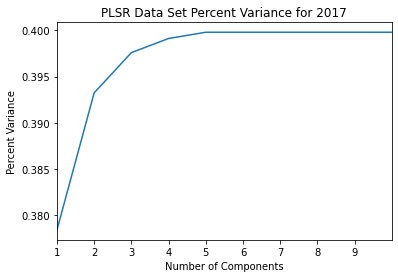

In [859]:
#PLSR 2017
#133 total countries in each dataframe
Y_WHRHLE2017 = pd.concat([dfWHR2017, dfHLE2017], axis=1)
tempdfWHR2017 = dfWHR2017.drop('Happiness Score', axis=1)
X2017 = tempdfWHR2017.values[:, 1:]
Y2017 = Y_WHRHLE2017[['Happiness Score', '2017']]
r2y2017 = np.zeros(133)

for i in range(0,133):
    plsrModel2017 = PLSRegression(n_components=i)
    plsrModel2017.fit(X2017, Y2017)
    r2y2017[i] = plsrModel2017.score(X2017,Y2017)

plt.plot(range(0,133), r2y2017)
plt.xlim(1,10)
plt.xticks(np.arange(1,10,1))
plt.xlabel('Number of Components')
plt.ylabel('Percent Variance')
plt.title('PLSR Data Set Percent Variance for 2017')
plt.show()

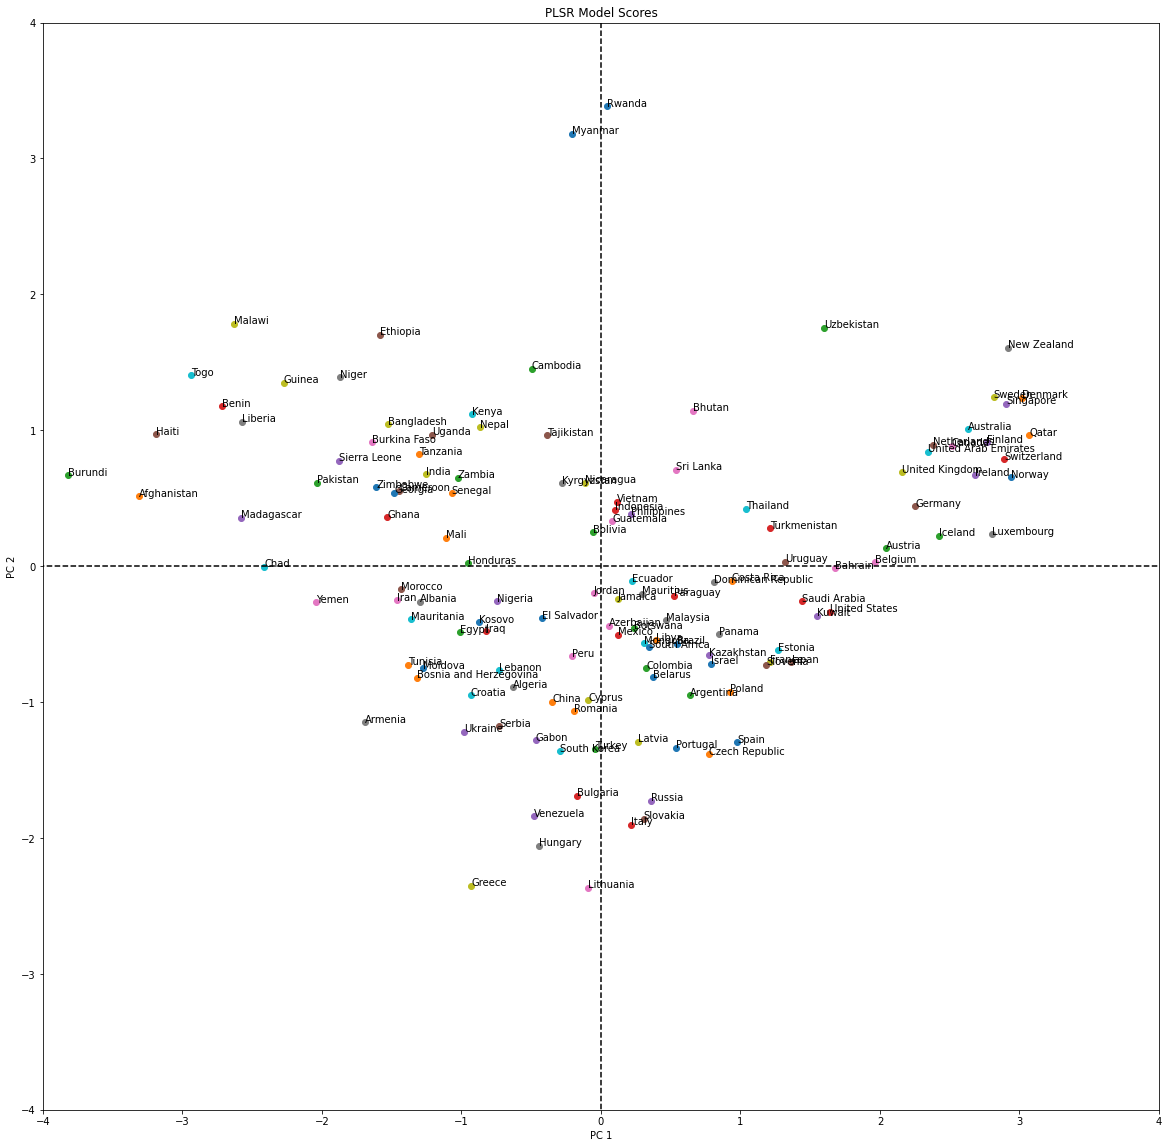

In [860]:
xScores2017 = plsrModel2017.x_scores_
yScores2017 = plsrModel2017.y_scores_
plt.figure(figsize=(20,20))

for i in range(0, 133):
    plt.scatter(xScores2017[i, 0], xScores2017[i, 1], label=dfWHR2017['Country'][i])
    plt.annotate(dfWHR2017['Country'][i], (xScores2017[i,0], xScores2017[i,1]))

plt.plot([0,0], [-10, 10], linestyle='--', color='k')
plt.plot([-10,10], [0,0], linestyle='--', color='k')
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PLSR Model Scores')
#plt.legend(bbox_to_anchor=(1.05,1.0), loc=2, prop={'size': 7}, ncol=4)
plt.show()

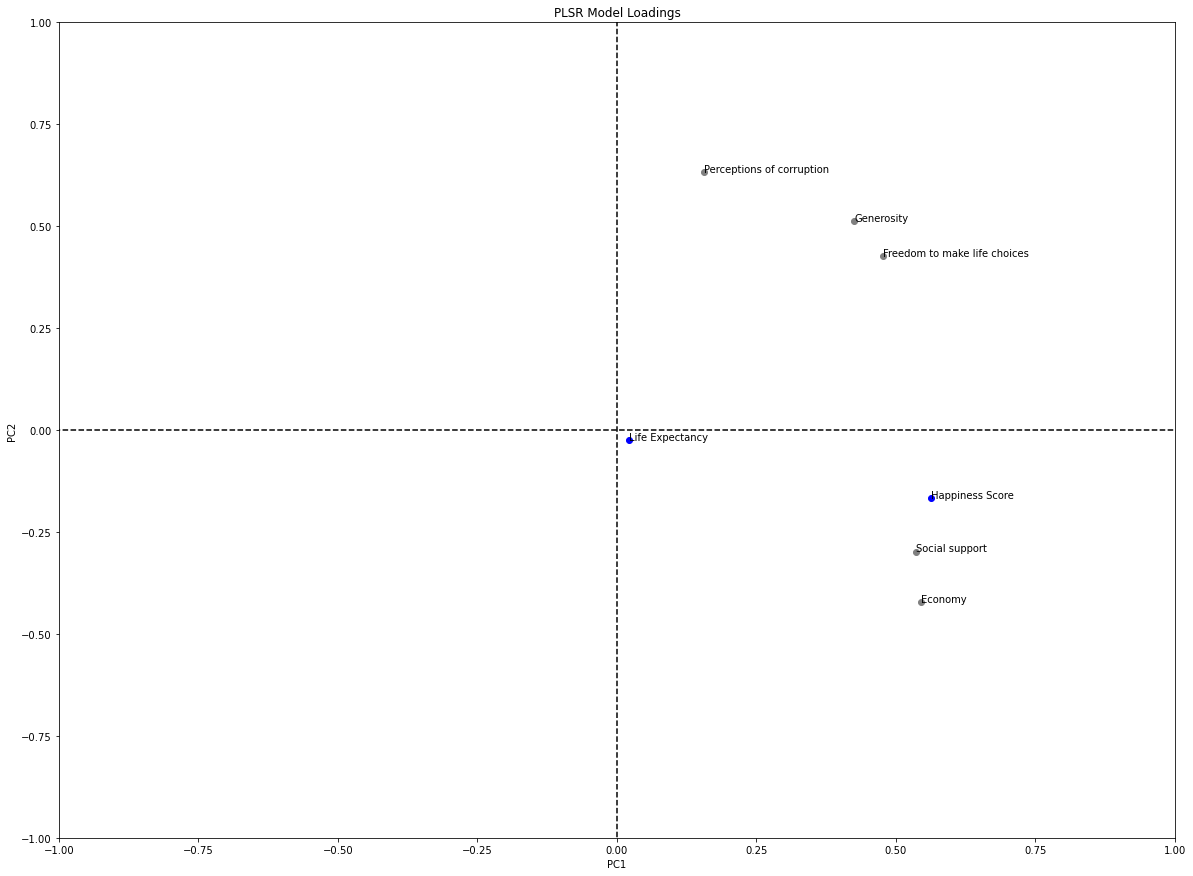

In [861]:
xLoad2017 = plsrModel2017.x_loadings_
yLoad2017 = plsrModel2017.y_loadings_

plt.figure(figsize=(20,15))
plt.scatter(xLoad2017[:,0], xLoad2017[:,1], c='gray')
plt.scatter(yLoad2017[:,0], yLoad2017[:,1], c='blue')
plt.annotate('Happiness Score', (yLoad2017[0,0], yLoad2017[0,1]))
plt.annotate('Life Expectancy', (yLoad2017[1,0], yLoad2017[1,1]))


labelArr = ['Economy', 'Social support', 'Freedom to make life choices', 'Perceptions of corruption', 'Generosity']

for i in range(xLoad2017.shape[0]):
        plt.text(xLoad2017[i,0], xLoad2017[i,1], labelArr[i])
        
plt.plot([0,0], [-5, 5], linestyle='--', color='k')
plt.plot([-5,5], [0,0], linestyle='--', color='k')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PLSR Model Loadings')
plt.show()

------

## PLSR 2018

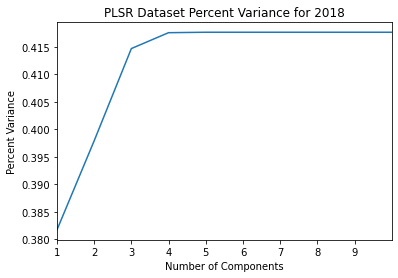

In [862]:
#PLSR 2018
#133 total countries in each dataframe
Y_WHRHLE2018 = pd.concat([dfWHR2018, dfHLE2018], axis=1)
tempdfWHR2018 = dfWHR2018.drop('Happiness Score', axis=1)
X2018 = tempdfWHR2018.values[:, 1:]
Y2018 = Y_WHRHLE2018[['Happiness Score', '2018']]
r2y2018 = np.zeros(133)

for i in range(0,133):
    plsrModel2018 = PLSRegression(n_components=i)
    plsrModel2018.fit(X2018, Y2018)
    r2y2018[i] = plsrModel2018.score(X2018,Y2018)

plt.plot(range(0,133), r2y2018)
plt.xlim(1,10)
plt.xticks(np.arange(1,10,1))
plt.xlabel('Number of Components')
plt.ylabel('Percent Variance')
plt.title('PLSR Dataset Percent Variance for 2018')
plt.show()

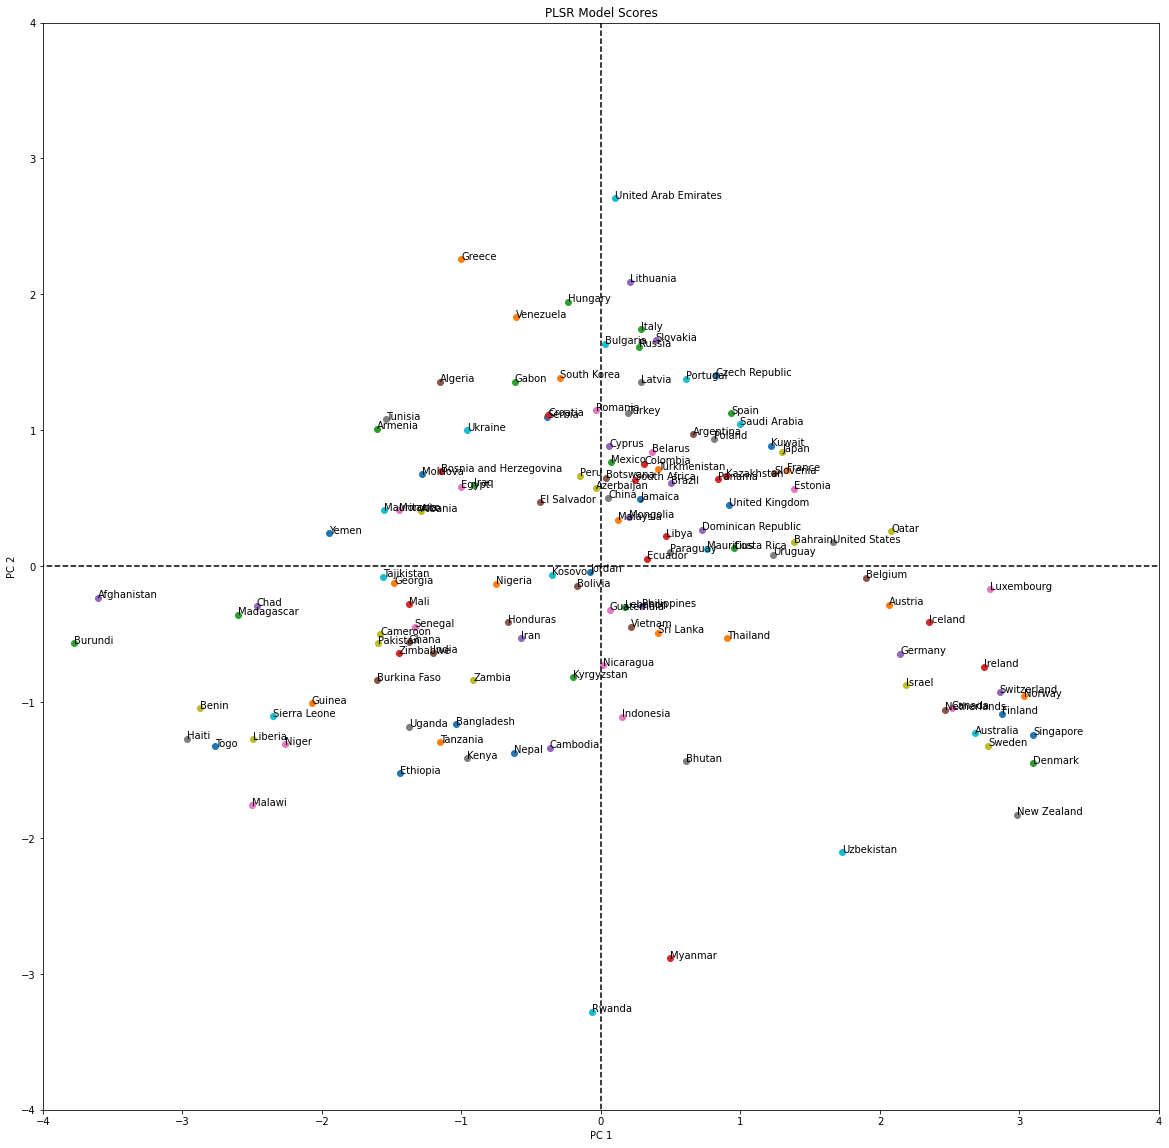

In [863]:
xScores2018 = plsrModel2018.x_scores_
yScores2018 = plsrModel2018.y_scores_
plt.figure(figsize=(20,20))

for i in range(0, 133):
    plt.scatter(xScores2018[i, 0], xScores2018[i, 1], label=dfWHR2018['Country'][i])
    plt.annotate(dfWHR2018['Country'][i], (xScores2018[i,0], xScores2018[i,1]))

plt.plot([0,0], [-10, 10], linestyle='--', color='k')
plt.plot([-10,10], [0,0], linestyle='--', color='k')
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PLSR Model Scores')
#plt.legend(bbox_to_anchor=(1.05,1.0), loc=2, prop={'size': 7}, ncol=4)
plt.show()

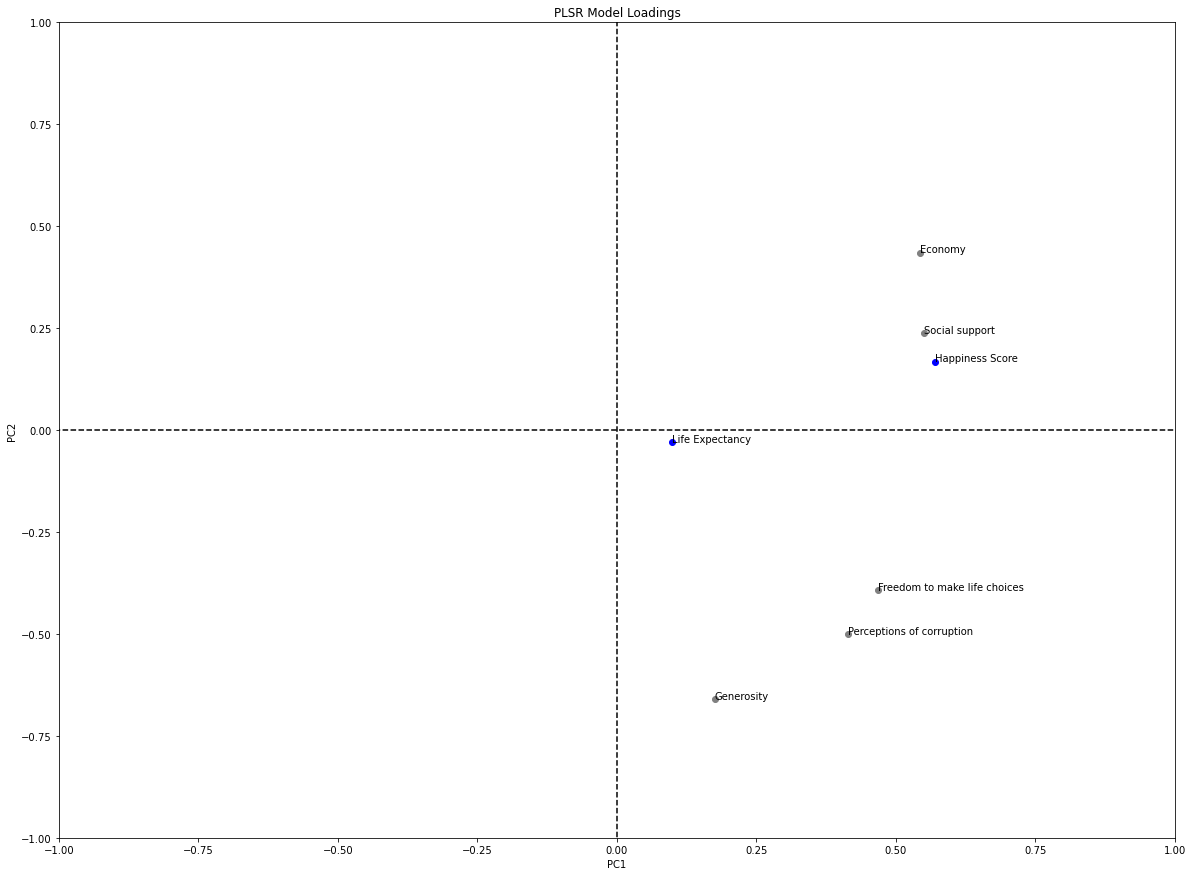

In [864]:
xLoad2018 = plsrModel2018.x_loadings_
yLoad2018 = plsrModel2018.y_loadings_

plt.figure(figsize=(20,15))
plt.scatter(xLoad2018[:,0], xLoad2018[:,1], c='gray')
plt.scatter(yLoad2018[:,0], yLoad2018[:,1], c='blue')
plt.annotate('Happiness Score', (yLoad2018[0,0], yLoad2018[0,1]))
plt.annotate('Life Expectancy', (yLoad2018[1,0], yLoad2018[1,1]))


labelArr = ['Economy', 'Social support', 'Freedom to make life choices', 'Perceptions of corruption', 'Generosity']

for i in range(xLoad2018.shape[0]):
        plt.text(xLoad2018[i,0], xLoad2018[i,1], labelArr[i])
        
plt.plot([0,0], [-5, 5], linestyle='--', color='k')
plt.plot([-5,5], [0,0], linestyle='--', color='k')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PLSR Model Loadings')
plt.show()

-----

## PLSR 2019

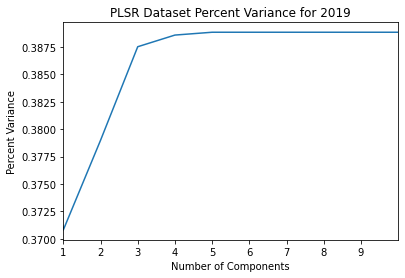

In [865]:
#PLSR 2019
#133 total countries in each dataframe
Y_WHRHLE2019 = pd.concat([dfWHR2019, dfHLE2019], axis=1)
tempdfWHR2019 = dfWHR2019.drop('Happiness Score', axis=1)
X2019 = tempdfWHR2019.values[:, 1:]
Y2019 = Y_WHRHLE2019[['Happiness Score', '2019']]
r2y2019 = np.zeros(133)

for i in range(0,133):
    plsrModel2019 = PLSRegression(n_components=i)
    plsrModel2019.fit(X2019, Y2019)
    r2y2019[i] = plsrModel2019.score(X2019,Y2019)

plt.plot(range(0,133), r2y2019)
plt.xlim(1,10)
plt.xticks(np.arange(1,10,1))
plt.xlabel('Number of Components')
plt.ylabel('Percent Variance')
plt.title('PLSR Dataset Percent Variance for 2019')
plt.show()

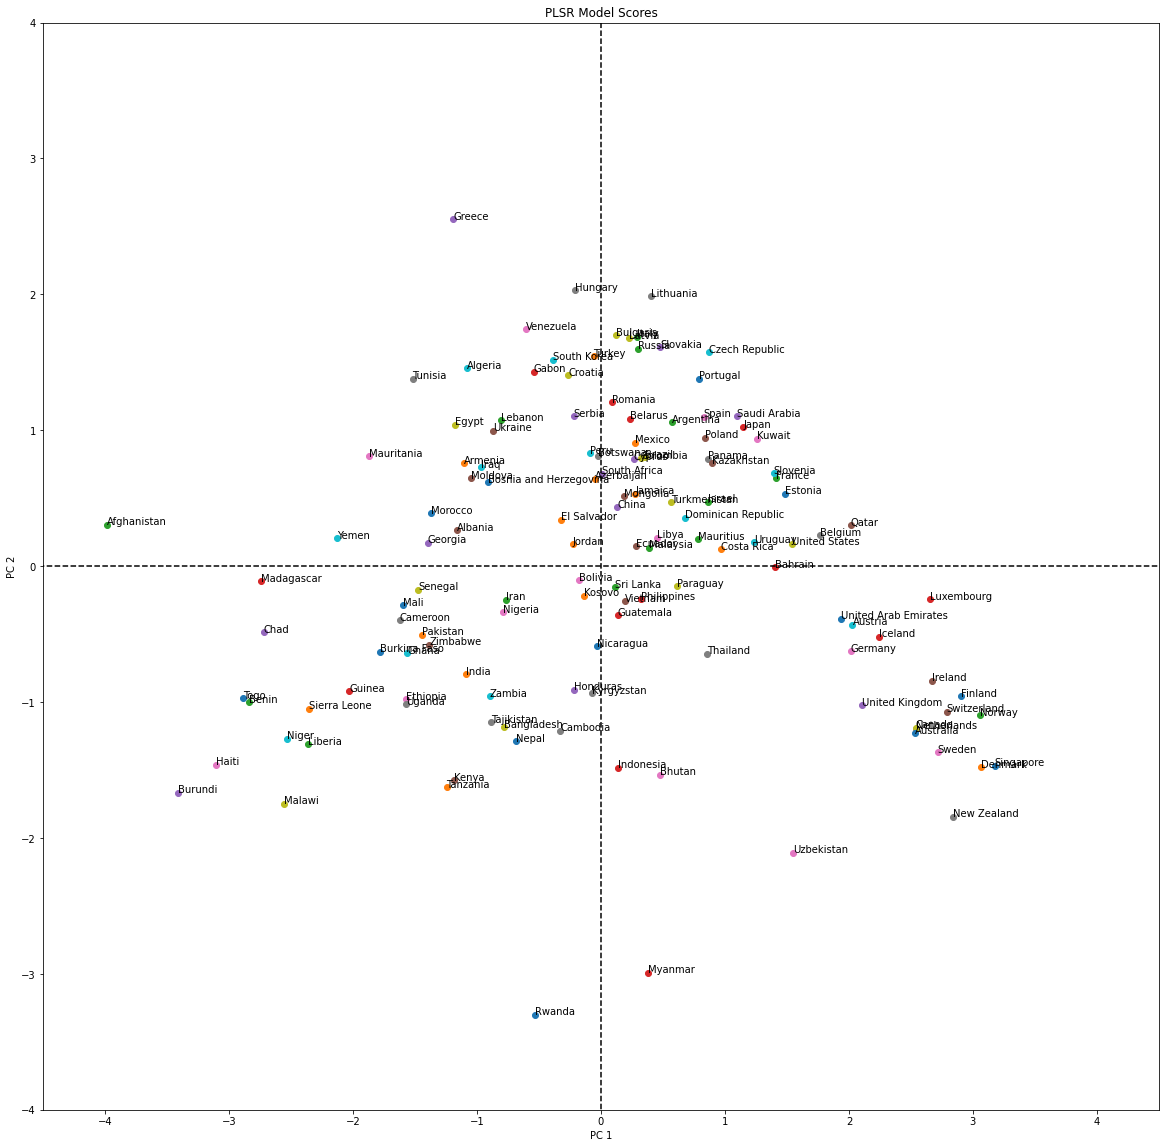

In [866]:
xScores2019 = plsrModel2019.x_scores_
yScores2019 = plsrModel2019.y_scores_
plt.figure(figsize=(20,20))

for i in range(0, 133):
    plt.scatter(xScores2019[i, 0], xScores2019[i, 1], label=dfWHR2019['Country'][i])
    plt.annotate(dfWHR2019['Country'][i], (xScores2019[i,0], xScores2019[i,1]))

plt.plot([0,0], [-10, 10], linestyle='--', color='k')
plt.plot([-10,10], [0,0], linestyle='--', color='k')
plt.xlim(-4.5,4.5)
plt.ylim(-4,4)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PLSR Model Scores')
#plt.legend(bbox_to_anchor=(1.05,1.0), loc=2, prop={'size': 7}, ncol=4)
plt.show()


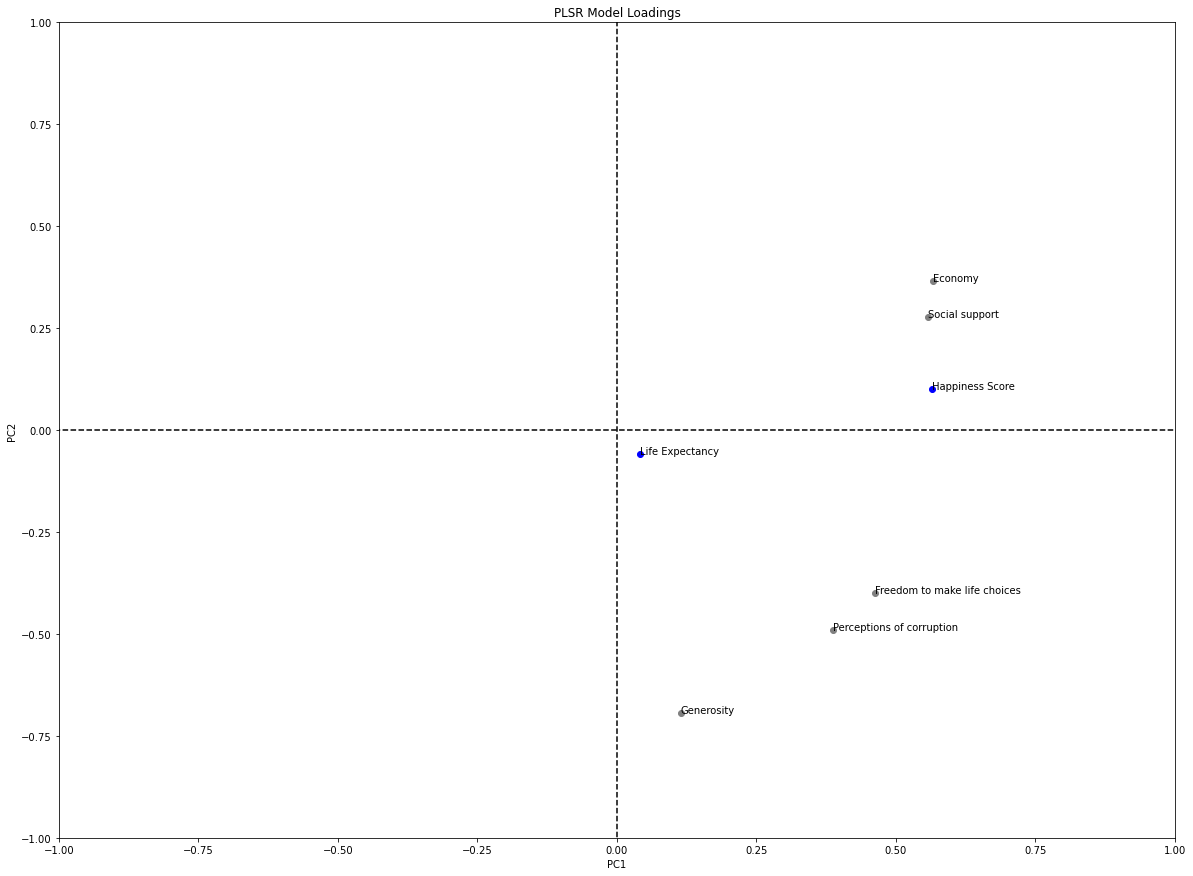

In [867]:
xLoad2019 = plsrModel2019.x_loadings_
yLoad2019 = plsrModel2019.y_loadings_

plt.figure(figsize=(20,15))
plt.scatter(xLoad2019[:,0], xLoad2019[:,1], c='gray')
plt.scatter(yLoad2019[:,0], yLoad2019[:,1], c='blue')
plt.annotate('Happiness Score', (yLoad2019[0,0], yLoad2019[0,1]))
plt.annotate('Life Expectancy', (yLoad2019[1,0], yLoad2019[1,1]))


labelArr = ['Economy', 'Social support', 'Freedom to make life choices', 'Perceptions of corruption', 'Generosity']

for i in range(xLoad2019.shape[0]):
        plt.text(xLoad2019[i,0], xLoad2019[i,1], labelArr[i])
        
plt.plot([0,0], [-5, 5], linestyle='--', color='k')
plt.plot([-5,5], [0,0], linestyle='--', color='k')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PLSR Model Loadings')
plt.show()

-----

## PLSR of the Average Values for Each Country Across All 5 Years
***Average of each metric + life expectancy for all 133 countries from 2015-2019**

In [868]:
#Averages of WHR for each country across all 5 years
avgWHR = np.zeros((133, 6))
for i in range(133):
    avgWHR_Hap = (dfWHR2015['Happiness Score'][i] + dfWHR2016['Happiness Score'][i] + dfWHR2017['Happiness Score'][i] + dfWHR2018['Happiness Score'][i] + dfWHR2019['Happiness Score'][i])/5.0
    avgWHR_Econ = (dfWHR2015['Economy'][i] + dfWHR2016['Economy'][i] + dfWHR2017['Economy'][i] + dfWHR2018['Economy'][i] + dfWHR2019['Economy'][i])/5.0
    avgWHR_Soc = (dfWHR2015['Social support'][i] + dfWHR2016['Social support'][i] + dfWHR2017['Social support'][i] + dfWHR2018['Social support'][i] + dfWHR2019['Social support'][i])/5.0
    avgWHR_Free = (dfWHR2015['Freedom to make life choices'][i] + dfWHR2016['Freedom to make life choices'][i] + dfWHR2017['Freedom to make life choices'][i] + dfWHR2018['Freedom to make life choices'][i] + dfWHR2019['Freedom to make life choices'][i])/5.0
    avgWHR_Cor = (dfWHR2015['Perceptions of corruption'][i] + dfWHR2016['Perceptions of corruption'][i] + dfWHR2017['Perceptions of corruption'][i] + dfWHR2018['Perceptions of corruption'][i] + dfWHR2019['Perceptions of corruption'][i])/5.0
    avgWHR_Gen = (dfWHR2015['Generosity'][i] + dfWHR2016['Generosity'][i] + dfWHR2017['Generosity'][i] + dfWHR2018['Generosity'][i] + dfWHR2019['Generosity'][i])/5.0
    avgWHR[i][0] = avgWHR_Hap
    avgWHR[i][1] = avgWHR_Econ
    avgWHR[i][2] = avgWHR_Soc
    avgWHR[i][3] = avgWHR_Free
    avgWHR[i][4] = avgWHR_Cor
    avgWHR[i][5] = avgWHR_Gen

avgdfWHR = pd.DataFrame(avgWHR, index=dfWHR2015['Country'], columns=['Happiness Score', 'Economy', 'Social support', 'Freedom to make life choices', 'Perceptions of corruption', 'Generosity'])

In [869]:
#Averages of HLE for each country across all 5 years
avgHLE = np.zeros((133,1))
for i in range(133):
    avgHLE_Life = (pd.to_numeric(dfHLE2015)[i] + pd.to_numeric(dfHLE2016)[i] + pd.to_numeric(dfHLE2017)[i] + pd.to_numeric(dfHLE2018)[i] + pd.to_numeric(dfHLE2019)[i])/5.0
    avgHLE[i][0] = avgHLE_Life

avgdfHLE = pd.DataFrame(avgHLE, index=dfHLE['Country'], columns=['Life Expectancy'])

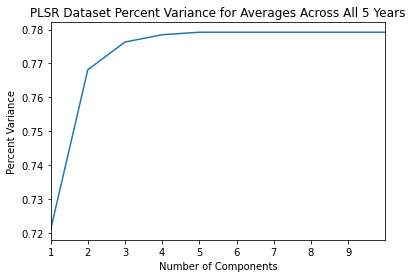

In [870]:
#PLSR averages across all years
# 133 total countries in each dataframe
Y_WHRHLEavg = pd.concat([avgdfWHR, avgdfHLE], axis=1)
tempdfWHRavg = avgdfWHR.drop('Happiness Score', axis=1)
Xavg = tempdfWHRavg.values[:,:]
Yavg = Y_WHRHLEavg[['Happiness Score', 'Life Expectancy']]
r2yavg = np.zeros(133)

for i in range(0,133):
    plsrModelavg = PLSRegression(n_components=i)
    plsrModelavg.fit(Xavg, Yavg)
    r2yavg[i] = plsrModelavg.score(Xavg,Yavg)

plt.plot(range(0,133), r2yavg)
plt.xlim(1,10)
plt.xticks(np.arange(1,10,1))
plt.xlabel('Number of Components')
plt.ylabel('Percent Variance')
plt.title('PLSR Dataset Percent Variance for Averages Across All 5 Years')
plt.show()

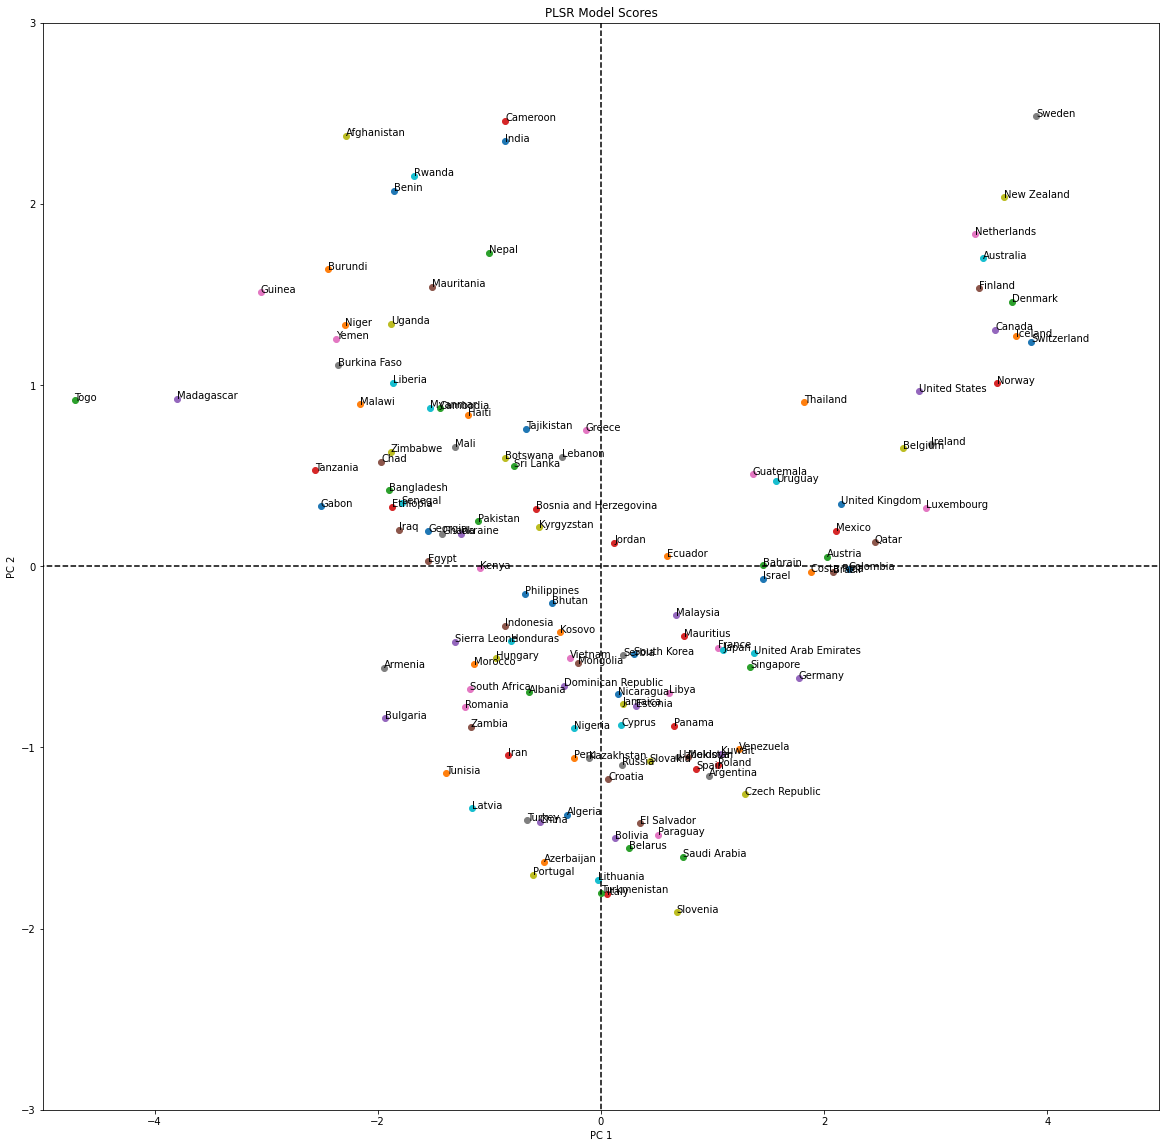

In [871]:
xScoresavg = plsrModelavg.x_scores_
yScoresavg = plsrModelavg.y_scores_
plt.figure(figsize=(20,20))

for i in range(0, 133):
    plt.scatter(xScoresavg[i, 0], xScoresavg[i, 1], label=dfWHR2015['Country'][i])
    plt.annotate(dfWHR2015['Country'][i], (xScoresavg[i,0], xScoresavg[i,1]))

plt.plot([0,0], [-10, 10], linestyle='--', color='k')
plt.plot([-10,10], [0,0], linestyle='--', color='k')
plt.xlim(-5,5)
plt.ylim(-3,3)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PLSR Model Scores')
#plt.legend(bbox_to_anchor=(1.05,1.0), loc=2, prop={'size': 7}, ncol=4)
plt.show()

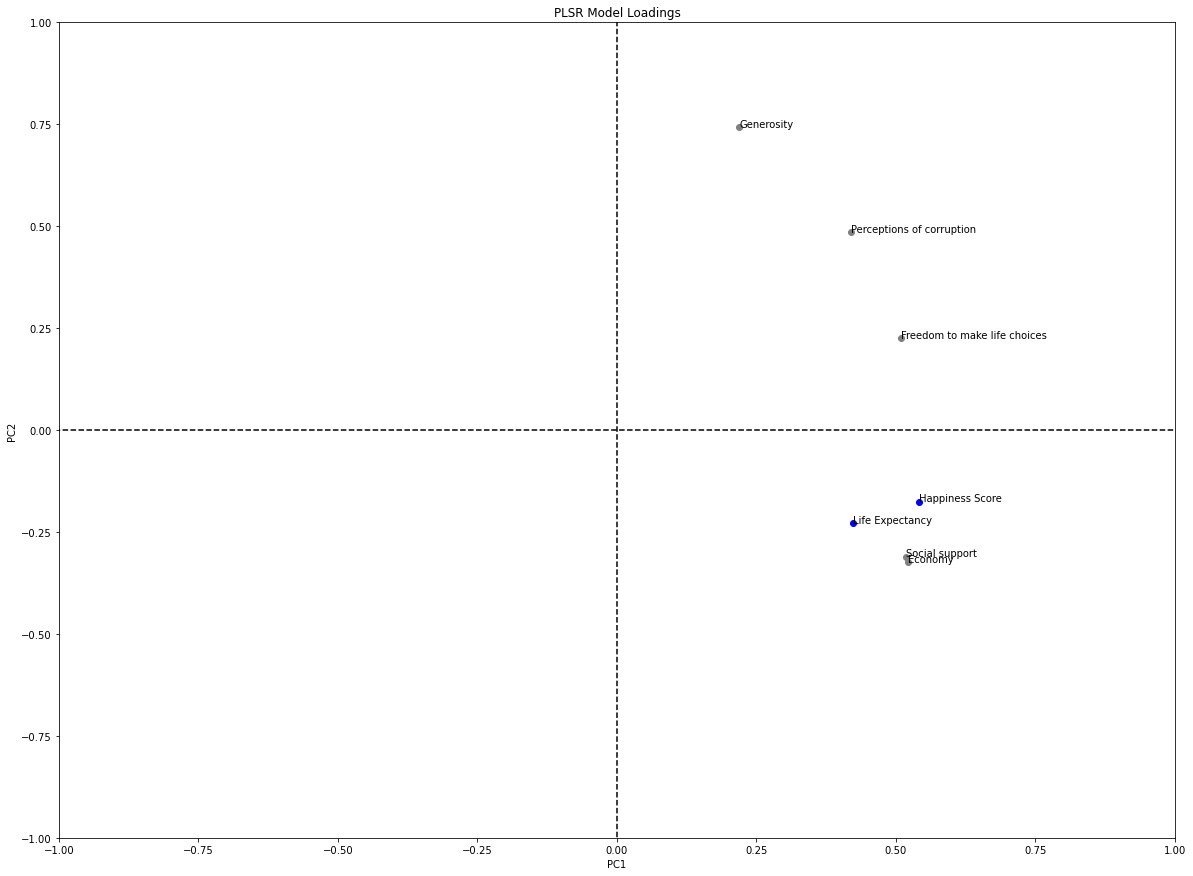

In [872]:
xLoadavg = plsrModelavg.x_loadings_
yLoadavg = plsrModelavg.y_loadings_

plt.figure(figsize=(20,15))
plt.scatter(xLoadavg[:,0], xLoadavg[:,1], c='gray')
plt.scatter(yLoadavg[:,0], yLoadavg[:,1], c='blue')
plt.annotate('Happiness Score', (yLoadavg[0,0], yLoadavg[0,1]))
plt.annotate('Life Expectancy', (yLoadavg[1,0], yLoadavg[1,1]))


labelArr = ['Economy', 'Social support', 'Freedom to make life choices', 'Perceptions of corruption', 'Generosity']

for i in range(xLoadavg.shape[0]):
        plt.text(xLoadavg[i,0], xLoadavg[i,1], labelArr[i])
        
plt.plot([0,0], [-5, 5], linestyle='--', color='k')
plt.plot([-5,5], [0,0], linestyle='--', color='k')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PLSR Model Loadings')
plt.show()

______

## PLSR of the averages of total values from WHR and HLE across all 5 years for all 5 countries
 ***Commented out since the disparity of scores/values between countries is too great and it yields no useful information (i.e. top ranking vs. bottom ranking)**

In [873]:
# #Averages of total WHR and HLE across all 5 years

# #WHR
# avgWHR_HScore = [dfWHR2015.values[:,1].mean(), dfWHR2016.values[:,1].mean(), dfWHR2017.values[:,1].mean(), 
#                    dfWHR2018.values[:,1].mean(), dfWHR2019.values[:,1].mean()]
# avgWHR_Econ = [dfWHR2015.values[:,2].mean(), dfWHR2016.values[:,2].mean(), dfWHR2017.values[:,2].mean(), 
#                    dfWHR2018.values[:,2].mean(), dfWHR2019.values[:,2].mean()]
# avgWHR_SSup = [dfWHR2015.values[:,3].mean(), dfWHR2016.values[:,3].mean(), dfWHR2017.values[:,3].mean(), 
#                    dfWHR2018.values[:,3].mean(), dfWHR2019.values[:,3].mean()]
# avgWHR_Freedom = [dfWHR2015.values[:,4].mean(), dfWHR2016.values[:,4].mean(), dfWHR2017.values[:,4].mean(), 
#                    dfWHR2018.values[:,4].mean(), dfWHR2019.values[:,4].mean()]
# avgWHR_Corrupt = [dfWHR2015.values[:,5].mean(), dfWHR2016.values[:,5].mean(), dfWHR2017.values[:,5].mean(), 
#                    dfWHR2018.values[:,5].mean(), dfWHR2019.values[:,5].mean()]
# avgWHR_Generosity = [dfWHR2015.values[:,6].mean(), dfWHR2016.values[:,6].mean(), dfWHR2017.values[:,6].mean(), 
#                    dfWHR2018.values[:,6].mean(), dfWHR2019.values[:,6].mean()]

# avgWHRt = np.zeros((6,5))
# for i in range(5):
#     avgWHRt[0][i] = avgWHR_HScore[i]
#     avgWHRt[1][i] = avgWHR_Econ[i]
#     avgWHRt[2][i] = avgWHR_SSup[i]
#     avgWHRt[3][i] = avgWHR_Freedom[i]
#     avgWHRt[4][i] = avgWHR_Corrupt[i]
#     avgWHRt[5][i] = avgWHR_Generosity[i]

# #where 0th index = 2015, 1st index = 2016, ...
# avgdfWHRTotal = pd.DataFrame(avgWHRt, index=['Happiness Score', 'Economy', 'Social support', 'Freedom to make life choices', 'Perceptions of corruption', 'Generosity'])

In [874]:
# # #Averages of total HLE across all 5 years
# avgdfHLE2015 = pd.to_numeric(dfHLE2015).mean()
# avgdfHLE2016 = pd.to_numeric(dfHLE2016).mean()
# avgdfHLE2017 = pd.to_numeric(dfHLE2017).mean()
# avgdfHLE2018 = pd.to_numeric(dfHLE2018).mean()
# avgdfHLE2019 = pd.to_numeric(dfHLE2019).mean()

# avgHLEt = [[avgdfHLE2015, avgdfHLE2016, avgdfHLE2017, avgdfHLE2018, avgdfHLE2019]]
# avgdfHLETotal = pd.DataFrame(avgHLEt, index=['Life Expectancy'])

In [875]:
# #PLSR total averages across all years

# Y_WHRHLEavgTotal = pd.concat([avgdfWHRTotal, avgdfHLETotal], axis=0)
# Y_WHRHLEavgTotal = Y_WHRHLEavgTotal.transpose()
# XavgTotal = avgdfWHRTotal.values[1:, :]
# YavgTotal = Y_WHRHLEavgTotal[['Happiness Score', 'Life Expectancy']]
# r2yavgTotal = np.zeros(133)

# for i in range(0,133):
#     plsrModelavgTotal = PLSRegression(n_components=i)
#     plsrModelavgTotal.fit(XavgTotal, YavgTotal)
#     r2yavgTotal[i] = plsrModelavgTotal.score(XavgTotal,YavgTotal)

# plt.plot(range(0,133), r2yavgTotal)
# plt.xlim(1,10)
# plt.xticks(np.arange(1,10,1))
# plt.xlabel('Number of Components')
# plt.ylabel('Percent Variance')
# plt.title('PLSR Dataset Percent Variance for Averages Across All 5 Years')
# plt.show()

In [876]:
# xScoresavgTotal = plsrModelavgTotal.x_scores_
# yScoresavgTotal = plsrModelavgTotal.y_scores_
# plt.figure(figsize=(20,10))

# years = ['2015', '2016', '2017', '2018', '2019']

# for i in range(0, 5):
#     plt.scatter(xScoresavgTotal[i, 0], xScoresavgTotal[i, 1], label=years[i])
#     plt.annotate(years[i], (xScoresavgTotal[i,0], xScoresavgTotal[i,1]))

# plt.plot([0,0], [-10, 10], linestyle='--', color='k')
# plt.plot([-10,10], [0,0], linestyle='--', color='k')
# plt.xlim(-3,3)
# plt.ylim(-1,1)
# plt.xlabel('PC 1')
# plt.ylabel('PC 2')
# plt.title('PLSR Model Scores')
# #plt.legend(bbox_to_anchor=(1.05,1.0), loc=2, prop={'size': 7}, ncol=4)
# plt.show()

In [877]:
# xLoadavgTotal = plsrModelavgTotal.x_loadings_
# yLoadavgTotal = plsrModelavgTotal.y_loadings_

# plt.figure(figsize=(20,15))
# plt.scatter(xLoadavgTotal[:,0], xLoadavgTotal[:,1], c='gray')
# plt.scatter(yLoadavgTotal[:,0], yLoadavgTotal[:,1], c='blue')
# plt.annotate('Happiness Score', (yLoadavgTotal[0,0], yLoadavgTotal[0,1]))
# plt.annotate('Life Expectancy', (yLoadavgTotal[1,0], yLoadavgTotal[1,1]))


# labelArr = ['Economy', 'Social support', 'Freedom to make life choices', 'Perceptions of corruption', 'Generosity']

# for i in range(xLoadavgTotal.shape[0]):
#         plt.text(xLoadavgTotal[i,0], xLoadavgTotal[i,1], labelArr[i])
        
# plt.plot([0,0], [-5, 5], linestyle='--', color='k')
# plt.plot([-5,5], [0,0], linestyle='--', color='k')
# plt.xlim(-1, 1)
# plt.ylim(-1, 1)
# plt.xlabel('PC1')
# plt.ylabel('PC2')
# plt.title('PLSR Model Loadings')
# plt.show()

----

## Cross Validation using Kfolds

In [878]:
#kfold for 2015
newYK2015 = np.array(Y2015['Happiness Score'])
kf2015 = KFold(n_splits=5, random_state = None, shuffle = True)
plsrModelK2015
for train_indexK2015, test_indexK2015 in kf2015.split(X2015):
    xtrainK2015 = X2015[train_indexK2015]
    xtestK2015 = X2015[test_indexK2015]
    ytrainK2015 = newYK2015[train_indexK2015]
    ytestK2015 = newYK2015[test_indexK2015]
    plsrModelK2015 = PLSRegression(n_components=4)
    plsrModelK2015.fit_transform(xtrainK2015, ytrainK2015)

scores2015 = cross_val_score(plsrModelK2015, X2015, newYK2015, cv = kf2015).mean()
print('Accuracy: %.3f' % scores2015)

Accuracy: 0.740


## Cross Validation using Leave One Out Cross Validation

0.9890960029966018


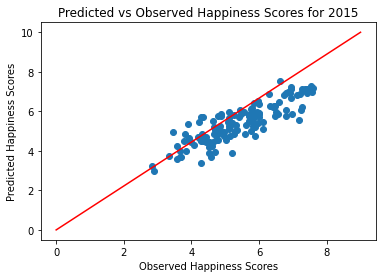

In [823]:
#LOOCV for 2015

loo2015 = LeaveOneOut()
ypredicted2015 = np.zeros(len(Y2015))
newY2015 = Y_WHRHLE2015['Happiness Score']

for train_index2015, test_index2015 in loo2015.split(X2015):
    xtrain2015 = X2015[train_index2015]
    xtest2015 = X2015[test_index2015]
    ytrain2015 = newY2015[train_index2015]
    plsr2015 = PLSRegression(n_components = 4)
    plsr2015.fit_transform(xtrain2015, ytrain2015)
    ypredicted2015[test_index2015] = plsr2015.predict(xtest2015)

plt.scatter(Y_WHRHLE2015['Happiness Score'], ypredicted2015)
plt.xlabel("Observed Happiness Scores")
plt.ylabel("Predicted Happiness Scores")
plt.title("Predicted vs Observed Happiness Scores for 2015")
plt.plot(np.linspace(0,10,10), color = 'r')

rsquared2015 = 1-(sum((ypredicted2015-newY2015)**2))/sum(newY2015**2)
print(rsquared2015)

0.9895362581683641


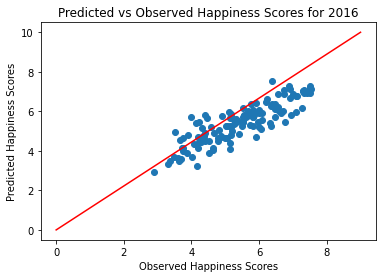

In [824]:
#LOOCV for 2016

loo2016 = LeaveOneOut()
ypredicted2016 = np.zeros(len(Y2016))
newY2016 = Y_WHRHLE2016['Happiness Score']

for train_index2016, test_index2016 in loo2016.split(X2016):
    xtrain2016 = X2016[train_index2016]
    xtest2016 = X2016[test_index2016]
    ytrain2016 = newY2016[train_index2016]
    plsr2016 = PLSRegression(n_components = 4)
    plsr2016.fit_transform(xtrain2016, ytrain2016)
    ypredicted2016[test_index2016] = plsr2016.predict(xtest2016)

plt.scatter(Y_WHRHLE2016['Happiness Score'], ypredicted2016)
plt.xlabel("Observed Happiness Scores")
plt.ylabel("Predicted Happiness Scores")
plt.title("Predicted vs Observed Happiness Scores for 2016")
plt.plot(np.linspace(0,10,10), color = 'r')

rsquared2016 = 1-(sum((ypredicted2016-newY2016)**2))/sum(newY2016**2)
print(rsquared2016)

0.9907938088621866


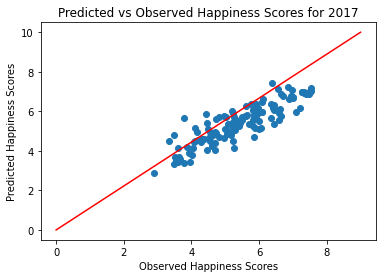

In [825]:
#LOOCV for 2017
loo2017 = LeaveOneOut()
ypredicted2017 = np.zeros(len(Y2017))
newY2017 = Y_WHRHLE2017['Happiness Score']

for train_index2017, test_index2017 in loo2017.split(X2017):
    xtrain2017 = X2017[train_index2017]
    xtest2017 = X2017[test_index2017]
    ytrain2017 = newY2017[train_index2017]
    plsr2017 = PLSRegression(n_components = 4)
    plsr2017.fit_transform(xtrain2017, ytrain2017)
    ypredicted2017[test_index2017] = plsr2017.predict(xtest2017)

plt.scatter(Y_WHRHLE2017['Happiness Score'], ypredicted2017)
plt.xlabel("Observed Happiness Scores")
plt.ylabel("Predicted Happiness Scores")
plt.title("Predicted vs Observed Happiness Scores for 2017")
plt.plot(np.linspace(0,10,10), color = 'r')

rsquared2017 = 1-(sum((ypredicted2017-newY2017)**2))/sum(newY2017**2)
print(rsquared2017)

0.9902798271978285


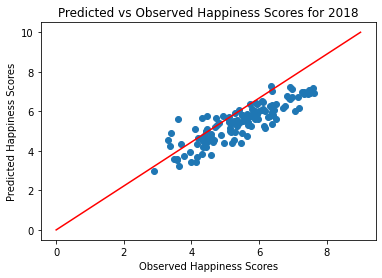

In [826]:
#LOOCV for 2018
loo2018 = LeaveOneOut()
ypredicted2018 = np.zeros(len(Y2018))
newY2018 = Y_WHRHLE2018['Happiness Score']

for train_index2018, test_index2018 in loo2018.split(X2018):
    xtrain2018 = X2018[train_index2018]
    xtest2018 = X2018[test_index2018]
    ytrain2018 = newY2018[train_index2018]
    plsr2018 = PLSRegression(n_components = 4)
    plsr2018.fit_transform(xtrain2018, ytrain2018)
    ypredicted2018[test_index2018] = plsr2018.predict(xtest2018)

plt.scatter(Y_WHRHLE2018['Happiness Score'], ypredicted2018)
plt.xlabel("Observed Happiness Scores")
plt.ylabel("Predicted Happiness Scores")
plt.title("Predicted vs Observed Happiness Scores for 2018")
plt.plot(np.linspace(0,10,10), color = 'r')

rsquared2018 = 1-(sum((ypredicted2018-newY2018)**2))/sum(newY2018**2)
print(rsquared2018)

0.9894770992999354


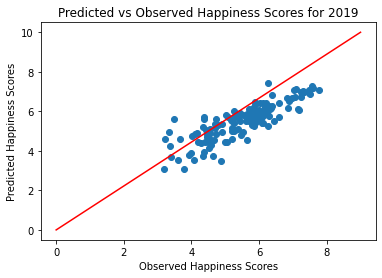

In [827]:
#LOOCV for 2019
loo2019 = LeaveOneOut()
ypredicted2019 = np.zeros(len(Y2019))
newY2019 = Y_WHRHLE2019['Happiness Score']

for train_index2019, test_index2019 in loo2019.split(X2019):
    xtrain2019 = X2019[train_index2019]
    xtest2019 = X2019[test_index2019]
    ytrain2019 = newY2019[train_index2019]
    plsr2019 = PLSRegression(n_components = 4)
    plsr2019.fit_transform(xtrain2019, ytrain2019)
    ypredicted2019[test_index2019] = plsr2019.predict(xtest2019)

plt.scatter(Y_WHRHLE2019['Happiness Score'], ypredicted2019)
plt.xlabel("Observed Happiness Scores")
plt.ylabel("Predicted Happiness Scores")
plt.title("Predicted vs Observed Happiness Scores for 2019")
plt.plot(np.linspace(0,10,10), color = 'r')

rsquared2019 = 1-(sum((ypredicted2019-newY2019)**2))/sum(newY2019**2)
print(rsquared2019)

0.9973195083864799


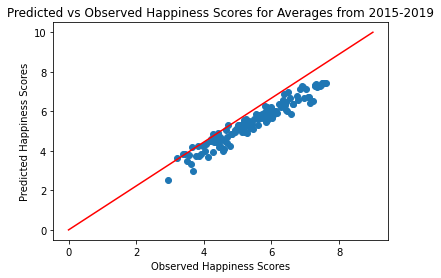

In [828]:
#LOOCV for averages across all 5 years
looAll = LeaveOneOut()
ypredictedAll = np.zeros(len(Yavg))
newYAll = Y_WHRHLEavg['Happiness Score']

for train_indexAll, test_indexAll in looAll.split(Xavg):
    xtrainAll = Xavg[train_indexAll]
    xtestAll = Xavg[test_indexAll]
    ytrainAll = newYAll[train_indexAll]
    plsrAll = PLSRegression(n_components = 4)
    plsrAll.fit_transform(xtrainAll, ytrainAll)
    ypredictedAll[test_indexAll] = plsrAll.predict(xtestAll)

plt.scatter(Y_WHRHLEavg['Happiness Score'], ypredictedAll)
plt.xlabel("Observed Happiness Scores")
plt.ylabel("Predicted Happiness Scores")
plt.title("Predicted vs Observed Happiness Scores for Averages from 2015-2019")
plt.plot(np.linspace(0,10,10), color = 'r')

rsquaredAll = 1-(sum((ypredictedAll-newYAll)**2))/sum(newYAll**2)
print(rsquaredAll)

# Leave One Out Group Cross Validation for all 5 Years 

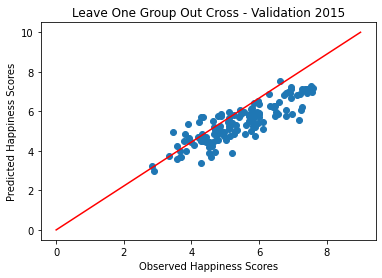

The R^2 value is 0.9890960029966018


In [836]:
#loogcv for 2015

logo2015 = LeaveOneGroupOut()
ypredictedG2015 = np.zeros(len(Y2015))
newYG2015 = Y_WHRHLE2015['Happiness Score']
arr2015 = np.zeros(len(Y2015))

for i in range(1):
    for j in range(133):
        arr2015[i*133+j] = j

for train_indexG2015, test_indexG2015 in logo2015.split(X2015,newYG2015,arr2015):
    xtrainG2015 = X2015[train_indexG2015]
    xtestG2015 = X2015[test_indexG2015]
    ytrainG2015 = newYG2015[train_indexG2015]
    plsrLogo2015 = PLSRegression(n_components = 4)
    plsrLogo2015.fit(xtrainG2015, ytrainG2015)
    ypredictedG2015[test_indexG2015] = np.squeeze(plsrLogo2015.predict(xtestG2015))
plt.scatter(newYG2015,ypredictedG2015)
plt.xlabel("Observed Happiness Scores")
plt.ylabel("Predicted Happiness Scores")
plt.title("Leave One Group Out Cross - Validation 2015")
plt.plot(np.linspace(0,10,10), color = 'r')
plt.show()

top15 = (sum((ypredictedG2015-newYG2015)**2))
bottom15 = sum(newYG2015**2)
q2y15 = 1-top15/bottom15
print("The R^2 value is",q2y15)

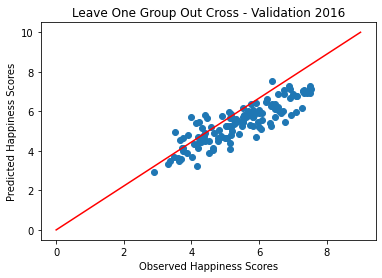

The R^2 value is 0.9895362581683641


In [837]:
#loogcv for 2016

logo2016 = LeaveOneGroupOut()
ypredictedG2016 = np.zeros(len(Y2016))
newYG2016 = Y_WHRHLE2016['Happiness Score']
arr2016 = np.zeros(len(Y2016))

for i in range(1):
    for j in range(133):
        arr2016[i*133+j] = j

for train_indexG2016, test_indexG2016 in logo2016.split(X2016,newYG2016,arr2016):
    xtrainG2016 = X2016[train_indexG2016]
    xtestG2016 = X2016[test_indexG2016]
    ytrainG2016 = newYG2016[train_indexG2016]
    plsrLogo2016 = PLSRegression(n_components = 4)
    plsrLogo2016.fit(xtrainG2016, ytrainG2016)
    ypredictedG2016[test_indexG2016] = np.squeeze(plsrLogo2016.predict(xtestG2016))
plt.scatter(newYG2016,ypredictedG2016)
plt.xlabel("Observed Happiness Scores")
plt.ylabel("Predicted Happiness Scores")
plt.title("Leave One Group Out Cross - Validation 2016")
plt.plot(np.linspace(0,10,10), color = 'r')
plt.show()

top16 = (sum((ypredictedG2016-newYG2016)**2))
bottom16 = sum(newYG2016**2)
q2y16 = 1-top16/bottom16
print("The R^2 value is",q2y16)

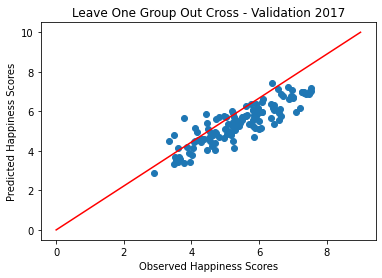

The R^2 value is 0.9907938088621866


In [838]:
#loogcv for 2017

logo2017 = LeaveOneGroupOut()
ypredictedG2017 = np.zeros(len(Y2017))
newYG2017 = Y_WHRHLE2017['Happiness Score']
arr2017 = np.zeros(len(Y2017))

for i in range(1):
    for j in range(133):
        arr2017[i*133+j] = j

for train_indexG2017, test_indexG2017 in logo2017.split(X2017,newYG2017,arr2017):
    xtrainG2017 = X2017[train_indexG2017]
    xtestG2017 = X2017[test_indexG2017]
    ytrainG2017 = newYG2017[train_indexG2017]
    plsrLogo2017 = PLSRegression(n_components = 4)
    plsrLogo2017.fit(xtrainG2017, ytrainG2017)
    ypredictedG2017[test_indexG2017] = np.squeeze(plsrLogo2017.predict(xtestG2017))
plt.scatter(newYG2017,ypredictedG2017)
plt.xlabel("Observed Happiness Scores")
plt.ylabel("Predicted Happiness Scores")
plt.title("Leave One Group Out Cross - Validation 2017")
plt.plot(np.linspace(0,10,10), color = 'r')
plt.show()

top17 = (sum((ypredictedG2017-newYG2017)**2))
bottom17 = sum(newYG2017**2)
q2y17 = 1-top17/bottom17
print("The R^2 value is",q2y17)

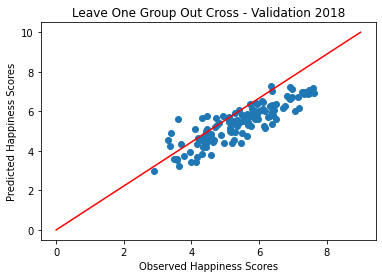

The R^2 value is 0.9902798271978285


In [839]:
#loogcv for 2018

logo2018 = LeaveOneGroupOut()
ypredictedG2018 = np.zeros(len(Y2018))
newYG2018 = Y_WHRHLE2018['Happiness Score']
arr2018 = np.zeros(len(Y2018))

for i in range(1):
    for j in range(133):
        arr2018[i*133+j] = j

for train_indexG2018, test_indexG2018 in logo2018.split(X2018,newYG2018,arr2018):
    xtrainG2018 = X2018[train_indexG2018]
    xtestG2018 = X2018[test_indexG2018]
    ytrainG2018 = newYG2018[train_indexG2018]
    plsrLogo2018 = PLSRegression(n_components = 4)
    plsrLogo2018.fit(xtrainG2018, ytrainG2018)
    ypredictedG2018[test_indexG2018] = np.squeeze(plsrLogo2018.predict(xtestG2018))
plt.scatter(newYG2018,ypredictedG2018)
plt.xlabel("Observed Happiness Scores")
plt.ylabel("Predicted Happiness Scores")
plt.title("Leave One Group Out Cross - Validation 2018")
plt.plot(np.linspace(0,10,10), color = 'r')
plt.show()

top18 = (sum((ypredictedG2018-newYG2018)**2))
bottom18 = sum(newYG2018**2)
q2y18 = 1-top18/bottom18
print("The R^2 value is",q2y18)

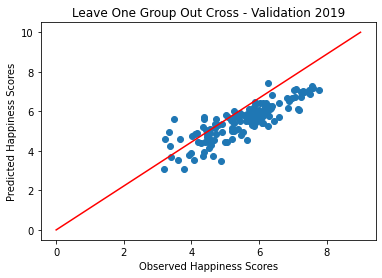

The R^2 value is 0.9894770992999354


In [840]:
#loogcv for 2019

logo2019 = LeaveOneGroupOut()
ypredictedG2019 = np.zeros(len(Y2019))
newYG2019 = Y_WHRHLE2019['Happiness Score']
arr2019 = np.zeros(len(Y2019))

for i in range(1):
    for j in range(133):
        arr2019[i*133+j] = j

for train_indexG2019, test_indexG2019 in logo2019.split(X2019,newYG2019,arr2019):
    xtrainG2019 = X2019[train_indexG2019]
    xtestG2019 = X2019[test_indexG2019]
    ytrainG2019 = newYG2019[train_indexG2019]
    plsrLogo2019 = PLSRegression(n_components = 4)
    plsrLogo2019.fit(xtrainG2019, ytrainG2019)
    ypredictedG2019[test_indexG2019] = np.squeeze(plsrLogo2019.predict(xtestG2019))
plt.scatter(newYG2019,ypredictedG2019)
plt.xlabel("Observed Happiness Scores")
plt.ylabel("Predicted Happiness Scores")
plt.title("Leave One Group Out Cross - Validation 2019")
plt.plot(np.linspace(0,10,10), color = 'r')
plt.show()

top19 = (sum((ypredictedG2019-newYG2019)**2))
bottom19 = sum(newYG2019**2)
q2y19 = 1-top19/bottom19
print("The R^2 value is",q2y19)

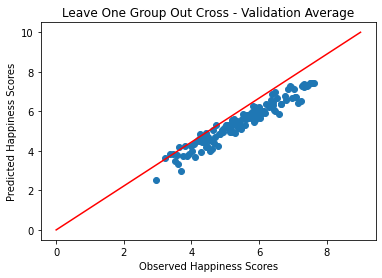

The R^2 value is 0.9973195083864799


In [842]:
#loogcv for all

logoavg = LeaveOneGroupOut()
ypredictedGavg = np.zeros(len(Yavg))
newYGavg = Y_WHRHLEavg['Happiness Score']
arravg = np.zeros(len(Yavg))

for i in range(1):
    for j in range(133):
        arravg[i*133+j] = j

for train_indexGavg, test_indexGavg in logoavg.split(Xavg,newYGavg,arravg):
    xtrainGavg = Xavg[train_indexGavg]
    xtestGavg = Xavg[test_indexGavg]
    ytrainGavg = newYGavg[train_indexGavg]
    plsrLogoavg = PLSRegression(n_components = 4)
    plsrLogoavg.fit(xtrainGavg, ytrainGavg)
    ypredictedGavg[test_indexGavg] = np.squeeze(plsrLogoavg.predict(xtestGavg))
plt.scatter(newYGavg,ypredictedGavg)
plt.xlabel("Observed Happiness Scores")
plt.ylabel("Predicted Happiness Scores")
plt.title("Leave One Group Out Cross - Validation Average")
plt.plot(np.linspace(0,10,10), color = 'r')
plt.show()

tavg = (sum((ypredictedGavg-newYGavg)**2))
bottavg = sum(newYGavg**2)
qavg = 1-tavg/bottavg
print("The R^2 value is",qavg)